In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from load_database import get_engine

engine = get_engine()

# Average Monthly Temperature by Province from 2000 to 2022
sql_all = """
          select Year, Province, Month, Temp
          from Province_Temp_All \
          """
df_all = pd.read_sql(sql_all, engine)

# In 2022
# Average Monthly Temperature, Pressure and Wind Speed by Province
sql_province = """
               select c.Month,
                      c.Province,
                      c.Temp,
                      c.WindSpeed,
                      p.Pressure
               from China_Map c
                        left join Province_Pressure p
                                  on c.Province = p.Province
                                      and c.Month = p.Month \
               """
df_province = pd.read_sql(sql_province, engine)

# Average Monthly Temperature by City
sql_city = """
           select Month, City, Temp
           from City_Temp \
           """
df_city = pd.read_sql(sql_city, engine)

In [57]:
scale_cols = ['Temp', 'Pressure', 'WindSpeed']
for df in [df_all, df_province, df_city]:
    for col in scale_cols:
        if col in df.columns:
            df[col] /= 10.0

## 2022气温异常性分析
以2000-2021为气候基准，计算2022年各省各月气温异常值（2022 - 基准均值）与z分数（异常/标准差）。通常|z|>=2可视为显著异常。


In [58]:
# 基准期（2000-2021）气候态
baseline = df_all[df_all['Year'].between(2000, 2021)]
clim = (baseline.groupby(['Province', 'Month'])['Temp'].agg(mean='mean', std='std').reset_index())

# 2022各省各月
temp_2022 = df_province[['Province', 'Month', 'Temp']].rename(columns={'Temp': 'Temp_2022'})

anomaly = temp_2022.merge(clim, on=['Province', 'Month'], how='left')
anomaly['anomaly'] = anomaly['Temp_2022'] - anomaly['mean']
anomaly['z'] = anomaly['anomaly'] / anomaly['std'].replace(0, np.nan)
anomaly.head()


,Province,Month,Temp_2022,mean,std,anomaly,z
0,上海,1,6.65711,5.319898,1.453721,1.337212,0.919855
1,云南,1,10.03160,10.044256,0.681284,-0.012656,-0.018577
2,内蒙古,1,-13.86450,-15.486436,2.417219,1.621936,0.670993
3,北京,1,-2.52032,-3.272831,1.855399,0.752511,0.405579
4,吉林,1,-15.23730,-15.298800,2.406136,0.061500,0.025560


In [59]:
overall = anomaly['anomaly'].mean()
pct_extreme = (anomaly['z'].abs() >= 2).mean()

prov_mean = anomaly.groupby('Province')['anomaly'].mean().sort_values(ascending=False)
top_warm = prov_mean.head(5)
top_cool = prov_mean.tail(5)

print(f"2022年全国各省各月平均异常: {overall:.2f} C")
print(f"|z|>=2 的月份占比: {pct_extreme:.1%}")
print('异常偏暖Top5省份:')
print(top_warm)
print('异常偏冷Top5省份:')
print(top_cool)


2022年全国各省各月平均异常: 0.42 C
|z|>=2 的月份占比: 14.8%
异常偏暖Top5省份:
Province
重庆    1.171276
湖北    1.128746
新疆    0.962369
陕西    0.901268
甘肃    0.901192
Name: anomaly, dtype: float64
异常偏冷Top5省份:
Province
广东   -0.032719
广西   -0.155411
海南   -0.196616
云南   -0.305644
江西   -0.504452
Name: anomaly, dtype: float64


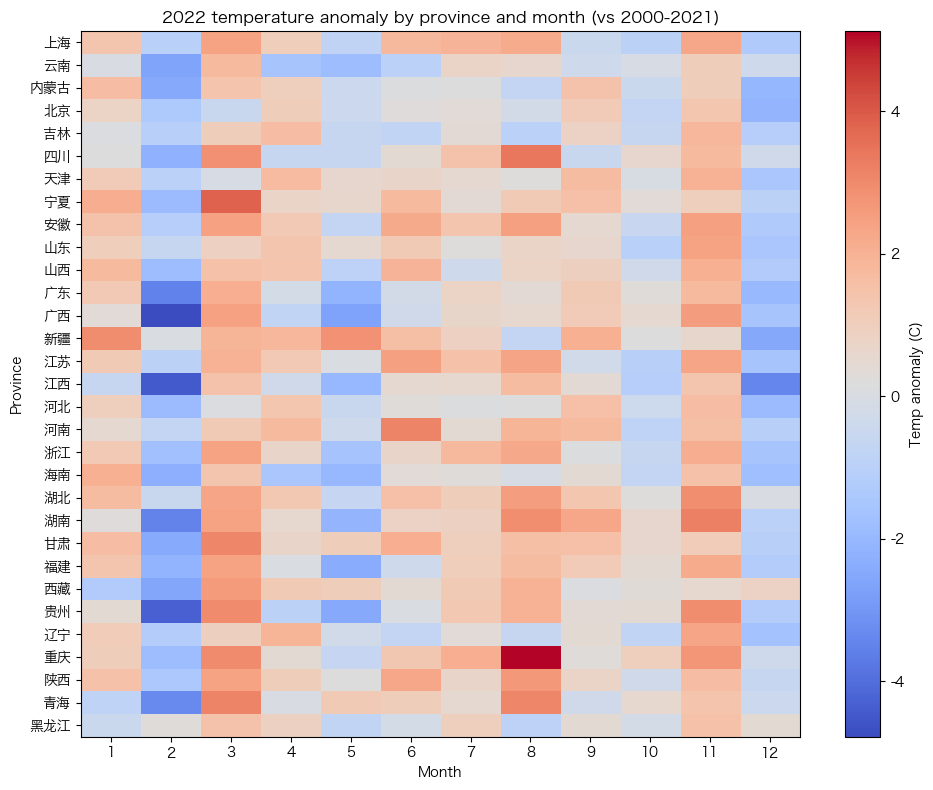

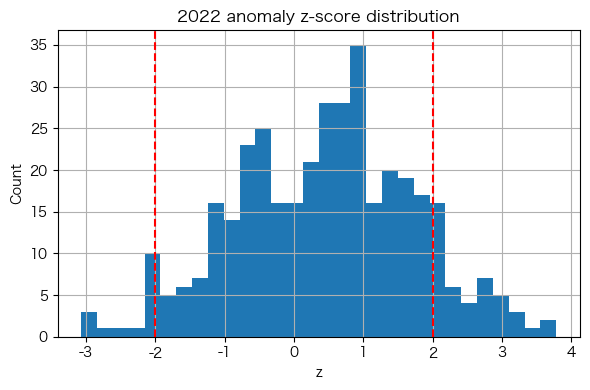

In [60]:
pivot = anomaly.pivot_table(index='Province', columns='Month', values='anomaly')
pivot = pivot.reindex(sorted(pivot.columns), axis=1)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Sans GB']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 8))
plt.imshow(pivot, aspect='auto', cmap='coolwarm')
plt.colorbar(label='Temp anomaly (C)')
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(len(pivot.columns)), list(pivot.columns))
plt.title('2022 temperature anomaly by province and month (vs 2000-2021)')
plt.xlabel('Month')
plt.ylabel('Province')
plt.tight_layout()
plt.savefig('fig_2022_anomaly_heatmap.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(6, 4))
anomaly['z'].hist(bins=30)
plt.axvline(2, color='r', linestyle='--')
plt.axvline(-2, color='r', linestyle='--')
plt.title('2022 anomaly z-score distribution')
plt.xlabel('z')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('fig_2022_anomaly_z_hist.png', dpi=300, bbox_inches='tight')


## 2000-2022各地区月均气温变化趋势
基于2000-2022年各省各月的均温序列，用线性回归斜率估计每10年的变化（C/decade）。


/var/folders/wg/9ryslwv550l9xnt72kk5m_nr0000gn/T/ipykernel_84336/3407639884.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(slope_per_decade)


升温最快Top5省份 (C/decade):
Province
湖北    1.135819
四川    0.684730
宁夏    0.558810
河南    0.537437
陕西    0.521616
dtype: float64
升温最慢Top5省份 (C/decade):
Province
广西    0.109172
吉林    0.090175
河北    0.054877
广东    0.020448
江西   -0.029449
dtype: float64


/var/folders/wg/9ryslwv550l9xnt72kk5m_nr0000gn/T/ipykernel_84336/3407639884.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prov_trend = annual.groupby("Province").apply(lambda g: np.polyfit(g["Year"], g["Temp"], 1)[0] * 10)


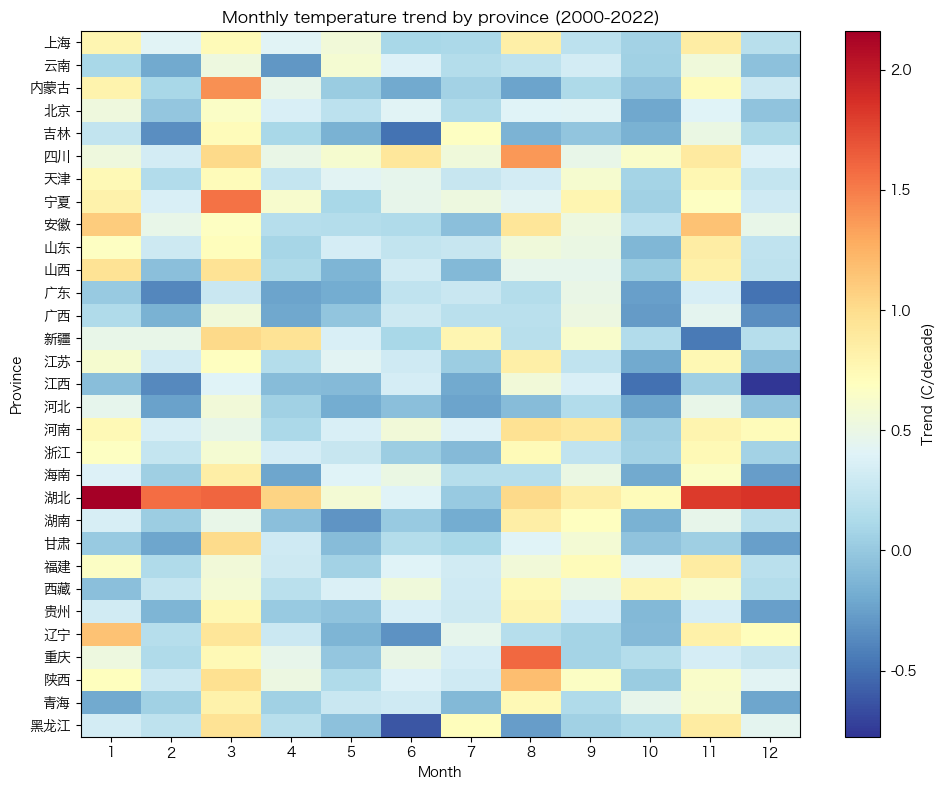

In [61]:
def slope_per_decade(group):
    x = group['Year'].values
    y = group['Temp'].values
    if len(np.unique(x)) < 2:
        return np.nan
    return np.polyfit(x, y, 1)[0] * 10


trend = (df_all.groupby(['Province', 'Month']).apply(slope_per_decade).reset_index(name='slope_per_decade'))

trend_pivot = trend.pivot_table(index='Province', columns='Month', values='slope_per_decade')
trend_pivot = trend_pivot.reindex(sorted(trend_pivot.columns), axis=1)

plt.figure(figsize=(10, 8))
plt.imshow(trend_pivot, aspect='auto', cmap='RdYlBu_r')
plt.colorbar(label='Trend (C/decade)')
plt.yticks(range(len(trend_pivot.index)), trend_pivot.index)
plt.xticks(range(len(trend_pivot.columns)), list(trend_pivot.columns))
plt.title('Monthly temperature trend by province (2000-2022)')
plt.xlabel('Month')
plt.ylabel('Province')
plt.tight_layout()
plt.savefig('fig_2000_2022_trend_heatmap.png', dpi=300, bbox_inches='tight')

annual = df_all.groupby(['Province', 'Year'])['Temp'].mean().reset_index()
prov_trend = annual.groupby('Province').apply(lambda g: np.polyfit(g['Year'], g['Temp'], 1)[0] * 10)
prov_trend = prov_trend.sort_values(ascending=False)
print('升温最快Top5省份 (C/decade):')
print(prov_trend.head(5))
print('升温最慢Top5省份 (C/decade):')
print(prov_trend.tail(5))


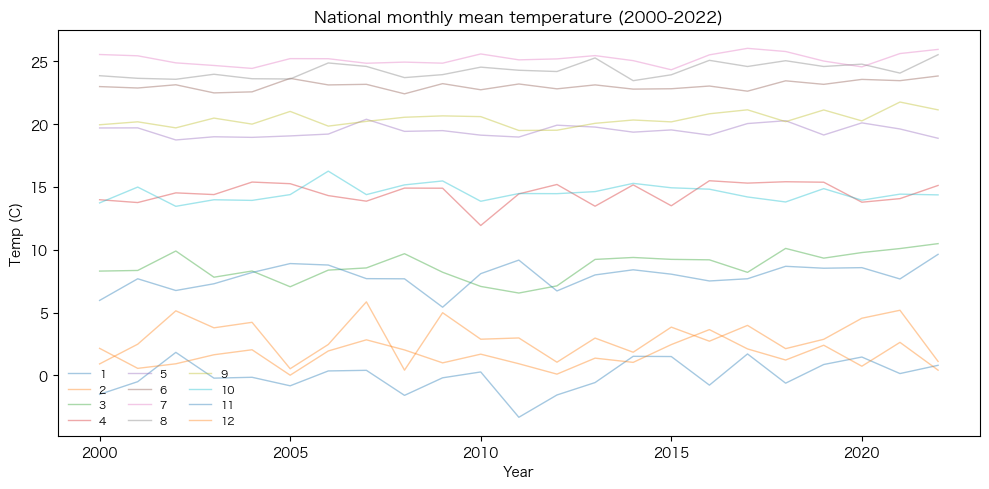

In [62]:
national = df_all.groupby(['Year', 'Month'])['Temp'].mean().reset_index()

plt.figure(figsize=(10, 5))
for m in range(1, 13):
    subset = national[national['Month'] == m]
    plt.plot(subset['Year'], subset['Temp'], alpha=0.4, linewidth=1, label=f"{m}")
plt.title('National monthly mean temperature (2000-2022)')
plt.xlabel('Year')
plt.ylabel('Temp (C)')
plt.legend(ncol=3, fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig('fig_national_monthly_mean.png', dpi=300, bbox_inches='tight')


## 2022温度异常与气压/风速关联
以2000-2021为基准计算2022各省各月温度异常，并分析其与当月气压、风速的相关性。


In [63]:
# 计算2022温度异常
baseline = df_all[df_all['Year'].between(2000, 2021)]
clim = (baseline.groupby(['Province', 'Month'])['Temp'].agg(mean='mean', std='std').reset_index())

prov_2022 = df_province[['Province', 'Month', 'Temp', 'Pressure', 'WindSpeed']].copy()
prov_2022 = prov_2022.rename(columns={'Temp': 'Temp_2022'})

prov_2022 = prov_2022.merge(clim, on=['Province', 'Month'], how='left')
prov_2022['anomaly'] = prov_2022['Temp_2022'] - prov_2022['mean']
prov_2022[['anomaly', 'Pressure', 'WindSpeed']].head()


,anomaly,Pressure,WindSpeed
0,1.337212,1026.16,3.08668
1,-0.012656,1016.11,2.31674
2,1.621936,1032.02,2.39336
3,0.752511,1029.01,2.24886
4,0.061500,1028.99,2.17345


In [64]:
# 总体相关性
cols = ['anomaly', 'Pressure', 'WindSpeed']
corr = prov_2022[cols].corr(method='pearson')
print(corr)

# 分月相关性
month_corr = (prov_2022.groupby('Month')[cols].corr(method='pearson').reset_index())
# 只保留 anomaly 与 Pressure/WindSpeed 的关系
month_corr = month_corr[month_corr['level_1'] == 'anomaly']
print(month_corr)


            anomaly  Pressure  WindSpeed
anomaly    1.000000 -0.318033   0.100973
Pressure  -0.318033  1.000000  -0.045715
WindSpeed  0.100973 -0.045715   1.000000
    Month  level_1  anomaly  Pressure  WindSpeed
0       1  anomaly      1.0  0.267816   0.090861
3       2  anomaly      1.0  0.424454   0.134462
6       3  anomaly      1.0 -0.495042  -0.235770
9       4  anomaly      1.0  0.416413   0.536046
12      5  anomaly      1.0 -0.366341   0.447678
15      6  anomaly      1.0 -0.253545   0.293687
18      7  anomaly      1.0 -0.183187   0.369153
21      8  anomaly      1.0 -0.403321   0.247261
24      9  anomaly      1.0  0.313534  -0.042613
27     10  anomaly      1.0 -0.381292  -0.187904
30     11  anomaly      1.0 -0.268563   0.292427
33     12  anomaly      1.0 -0.368868  -0.166994


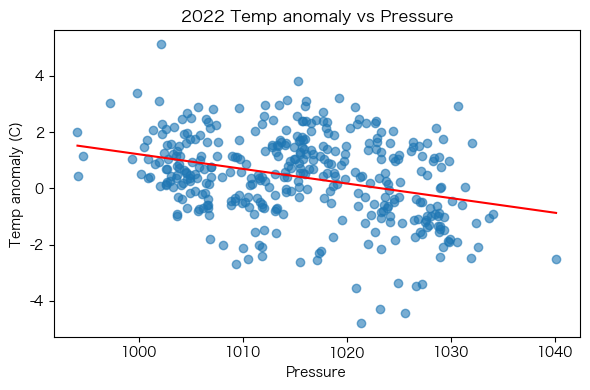

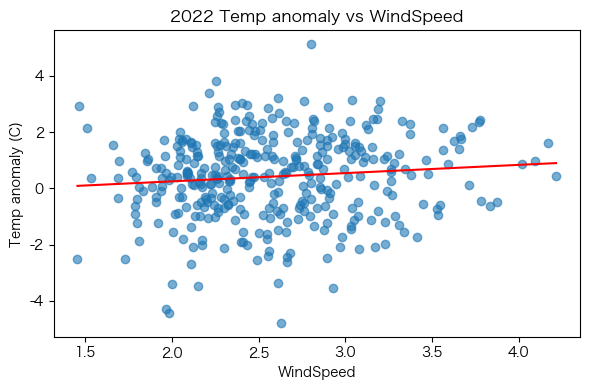

In [65]:
# 散点图与回归线
plt.figure(figsize=(6, 4))
plt.scatter(prov_2022['Pressure'], prov_2022['anomaly'], alpha=0.6)
coef = np.polyfit(prov_2022['Pressure'], prov_2022['anomaly'], 1)
x = np.linspace(prov_2022['Pressure'].min(), prov_2022['Pressure'].max(), 100)
plt.plot(x, coef[0] * x + coef[1], color='red')
plt.title('2022 Temp anomaly vs Pressure')
plt.xlabel('Pressure')
plt.ylabel('Temp anomaly (C)')
plt.tight_layout()
plt.savefig('fig_2022_anomaly_vs_pressure.png', dpi=300, bbox_inches='tight')

plt.figure(figsize=(6, 4))
plt.scatter(prov_2022['WindSpeed'], prov_2022['anomaly'], alpha=0.6)
coef = np.polyfit(prov_2022['WindSpeed'], prov_2022['anomaly'], 1)
x = np.linspace(prov_2022['WindSpeed'].min(), prov_2022['WindSpeed'].max(), 100)
plt.plot(x, coef[0] * x + coef[1], color='red')
plt.title('2022 Temp anomaly vs WindSpeed')
plt.xlabel('WindSpeed')
plt.ylabel('Temp anomaly (C)')
plt.tight_layout()
plt.savefig('fig_2022_anomaly_vs_windspeed.png', dpi=300, bbox_inches='tight')


## 2023-2027各省月均温预测
基于2000-2022年各省各月历史序列，按“省份-月份”分别做线性趋势外推，得到2023-2027的预测值。


In [66]:
# 线性趋势预测（按省份-月份）
def predict_group(g, years):
    x = g['Year'].values
    y = g['Temp'].values
    if len(set(x)) < 2:
        # 数据不足时返回空
        return None
    coef = np.polyfit(x, y, 1)
    preds = coef[0] * years + coef[1]
    out = pd.DataFrame(
        {'Province': g['Province'].iloc[0], 'Month': g['Month'].iloc[0], 'Year': years, 'Temp_pred': preds, })
    return out


future_years = np.arange(2023, 2028)

pred_list = []
for (prov, month), g in df_all.groupby(['Province', 'Month']):
    pred = predict_group(g, future_years)
    if pred is not None:
        pred_list.append(pred)

pred_2023_2027 = pd.concat(pred_list, ignore_index=True)
pred_2023_2027.head()


,Province,Month,Year,Temp_pred
0,上海,1,2023,6.308810
1,上海,1,2024,6.386374
2,上海,1,2025,6.463939
3,上海,1,2026,6.541503
4,上海,1,2027,6.619067


In [67]:
# export prediction.csv
pred_2023_2027.to_csv('prediction.csv', index=False)
print('saved prediction.csv')


saved prediction.csv
